In [1]:
import pandas as pd
from datetime import datetime

# Company list

In [2]:
df = pd.read_csv("stock_data_with_dates.csv")
df['Date'] = pd.to_datetime(df['Date'])

In [3]:
df_2018 = df[df['Date'] == '2018-01-02']

In [4]:
# df_2018['Ticker'].nunique()
df_2022_start = df[df['Date'] == '2022-01-03']
df_2022_end = df[df['Date'] == '2022-12-30']

In [5]:
company_list = df_2018['Ticker'].unique().tolist()

In [7]:
#company_list_2022 = df_2022['Ticker'].unique().tolist()

In [9]:
# company_list_df = pd.DataFrame({'company': company_list})
# company_list_df.to_csv('company_list_df.csv', index=False)

# Portfolio Selection Optimization
This model is an example of the classic [Markowitz portfolio selection optimization model](https://en.wikipedia.org/wiki/Markowitz_model). We want to find the fraction of the portfolio to invest among a set of stocks that balances risk and return. It is a Quadratic Programming (QP) model with vector and matrix data for returns and risk, respectively. This is best suited to a matrix formulation, so we use the Gurobi Python *matrix* interface. The basic model is fairly simple, so we also solve it parametrically to find the efficient frontier.

**Download the Repository** <br /> 
You can download the repository containing this and other examples by clicking [here](https://github.com/Gurobi/modeling-examples/archive/master.zip). 


## Model Formulation
### Parameters

We use the [Greek values](https://en.wikipedia.org/wiki/Greeks_\(finance\)) that are traditional in finance:

- $\delta$: n-element vector measuring the change in price for each stock
- $\sigma$: n x n matrix measuring the covariance among stocks

There is one additional parameter when solving the model parametrically:

- r: target return


### Decision Variables
- $x \ge 0$: n-element vector where each element represents the fraction of the porfolio to invest in each stock

### Objective Function
Minimize the total risk, a convex quadratic function:

\begin{equation}
\min x^t \cdot \sigma \cdot x
\end{equation}

### Constraints

Allocate the entire portfolio: the total investments should be 1.0 (100%), where $e$ is a unit vector (all 1's):

\begin{equation}
e \cdot x = 1
\end{equation}


Return: When we solve the model parametrically for different return values $r$, we add a constraint on the target return:

\begin{equation}
\delta \cdot x = r
\end{equation}

## Python Implementation
### Stock data
Use [yfinance](https://pypi.org/project/yfinance/) library to get the latest 2 years of _actual stock data_ from the 20 most profitable US companies, [according to Wikipedia in April 2021](https://en.wikipedia.org/wiki/List_of_largest_companies_in_the_United_States_by_revenue#List_of_companies_by_profit).

In [10]:
import yfinance as yf

data = yf.download(company_list, start="2018-01-01", end="2023-03-31", interval = "1d")
# data.to_csv('data.csv')

[*********************100%%**********************]  484 of 484 completed


### Compute Greeks
Using the downloaded stock data, find the delta (return), sigma (covariance) and standard deviation values for stock prices:

In [11]:
import numpy as np

closes = np.transpose(np.array(data.Close)) # matrix of daily closing prices
absdiff = np.diff(closes)                   # change in closing price each day
reldiff = np.divide(absdiff, closes[:,:-1]) # relative change in daily closing price
delta = np.mean(reldiff, axis=1)            # mean price change
sigma = np.cov(reldiff)                     # covariance (standard deviations) between 2 stocks
std = np.std(reldiff, axis=1)               # standard deviation

In [12]:
closes.shape # number of stocks x days
absdiff.shape # number of stocks x (days - 1)
reldiff.shape # number of stocks x (days - 1)
delta.shape # vector of number of stocks
sigma.shape # number of stocks x number of stocks
std.shape # vector of number of stocks (1 value per stock)

(484,)

In [13]:
sigma

array([[0.00034138, 0.00022613, 0.00015123, ..., 0.00026624, 0.00018299,
        0.00020979],
       [0.00022613, 0.00147695, 0.00027525, ..., 0.00034328, 0.00049723,
        0.00017955],
       [0.00015123, 0.00027525, 0.00046347, ..., 0.00020442, 0.00022787,
        0.00015891],
       ...,
       [0.00026624, 0.00034328, 0.00020442, ..., 0.00067161, 0.00027139,
        0.00023879],
       [0.00018299, 0.00049723, 0.00022787, ..., 0.00027139, 0.00066906,
        0.00013412],
       [0.00020979, 0.00017955, 0.00015891, ..., 0.00023879, 0.00013412,
        0.00031157]])

In [14]:
absdiff

array([[ 1.72000122, -0.51999664,  1.09999847, ..., -0.44000244,
         1.22000122,  0.63999939],
       [-0.65000153,  0.32999802, -0.01999664, ...,  0.03999996,
         0.37000084,  0.11999989],
       [ 0.96000671,  3.94999695,  1.18000031, ...,  1.        ,
         1.81000519,  1.05999756],
       ...,
       [ 2.05999756,  2.09000397,  1.68000031, ...,  1.29000854,
         5.97000122, 12.98999023],
       [-0.06000137,  0.20999908,  0.02000046, ...,  0.62000084,
         1.09000015, -0.74000168],
       [ 0.33000183,  0.43000031,  0.83000183, ..., -0.67001343,
        -2.37998962,  1.48999023]])

In [15]:
reldiff

array([[ 0.02544381, -0.00750139,  0.01598835, ..., -0.00330655,
         0.00919853,  0.00478147],
       [-0.01226649,  0.00630489, -0.00037966, ...,  0.00286944,
         0.02646644,  0.00836236],
       [ 0.00904898,  0.03689862,  0.01063063, ...,  0.00871536,
         0.01563855,  0.00901742],
       ...,
       [ 0.01986306,  0.01975989,  0.01557575, ...,  0.00446586,
         0.02057557,  0.04386732],
       [-0.00118346,  0.0041469 ,  0.00039332, ...,  0.02113879,
         0.03639399, -0.02384026],
       [ 0.00459805,  0.00596394,  0.01144357, ..., -0.00404329,
        -0.01442068,  0.00916015]])

# Jan 2018 - Mar 2023

## Minimize risk by solving QP model

In [16]:
import gurobipy as gp
from gurobipy import GRB
from math import sqrt

# Create an empty model
m = gp.Model('portfolio')

# Add matrix variable for the stocks
x = m.addMVar(len(company_list))

# Objective is to minimize risk (squared).  This is modeled using the
# covariance matrix, which measures the historical correlation between stocks
portfolio_risk = x @ sigma @ x
m.setObjective(portfolio_risk, GRB.MINIMIZE)

# Fix budget with a constraint
m.addConstr(x.sum() == 1, 'budget')

# Verify model formulation
m.write('portfolio_selection_optimization.lp')

# Optimize model to find the minimum risk portfolio
m.optimize()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-21
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1 rows, 484 columns and 484 nonzeros
Model fingerprint: 0x0f093689
Model has 117370 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [4e-07, 7e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.07s
Presolved: 1 rows, 484 columns, 484 nonzeros
Presolved model has 117370 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 483
 AA' NZ     : 1.169e+05
 Factor NZ  : 1.174e+05 (roughly 2 MB of memory)
 Factor Ops : 3.791e+07 (less than 1 second per iteration)
 Threads    : 8

                  Objective                Residual
Iter       Primal          Dual         Pri

## Display minimum risk portfolio using Pandas

In [17]:
import pandas as pd
minrisk_volatility = sqrt(m.ObjVal)
minrisk_return = delta @ x.X
pd.DataFrame(data=np.append(x.X, [minrisk_volatility, minrisk_return]),
             index=company_list + ['Volatility', 'Expected Return'],
             columns=['Minimum Risk Portfolio'])

,Minimum Risk Portfolio
AAPL,7.509001e-09
MSFT,1.102283e-08
AMZN,7.616428e-09
GOOGL,4.809499e-09
GOOG,4.554400e-07
...,...
DVA,4.537129e-09
DISH,1.074384e-08
NWS,7.032244e-09
Volatility,8.776316e-03


## Compute the efficient frontier
Solve the QP parametrically to find the lowest risk portfolio for different expected returns.

In [18]:
# Create an expression representing the expected return for the portfolio
portfolio_return = delta @ x
target = m.addConstr(portfolio_return == minrisk_return, 'target')

# Solve for efficient frontier by varying target return
frontier = np.empty((2,0))
for r in np.linspace(delta.min(), delta.max(), 25):
    target.rhs = r
    m.optimize()
    frontier = np.append(frontier, [[sqrt(m.ObjVal)],[r]], axis=1)

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2 rows, 484 columns and 968 nonzeros
Model fingerprint: 0x16154db9
Model has 117370 quadratic objective terms
Coefficient statistics:
  Matrix range     [3e-07, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [4e-07, 7e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 1e+00]
Presolve time: 0.03s
Presolved: 2 rows, 484 columns, 968 nonzeros
Presolved model has 117370 quadratic objective terms
Ordering time: 0.03s

Barrier statistics:
 Free vars  : 483
 AA' NZ     : 1.174e+05
 Factor NZ  : 1.179e+05 (roughly 2 MB of memory)
 Factor Ops : 3.815e+07 (less than 1 second per iteration)
 Threads    : 8

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.13648436e+05 -2.13648436e+05  2.66e+05 1.92e-03  1.

  14   1.26639245e-04  1.25278585e-04  4.81e-16 6.94e-18  2.81e-09     2s
  15   1.25534326e-04  1.25405811e-04  6.14e-16 6.07e-18  2.66e-10     2s
  16   1.25411277e-04  1.25411009e-04  3.38e-15 4.68e-18  5.53e-13     2s

Barrier solved model in 16 iterations and 2.01 seconds (0.25 work units)
Optimal objective 1.25411277e-04

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2 rows, 484 columns and 968 nonzeros
Model fingerprint: 0x73562f0e
Model has 117370 quadratic objective terms
Coefficient statistics:
  Matrix range     [3e-07, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [4e-07, 7e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-05, 1e+00]
Presolve time: 0.05s
Presolved: 2 rows, 484 columns, 968 nonzeros
Presolved model has 117370 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 483
 AA' 

   3   1.64823467e+03 -1.68205279e+03  5.71e+01 2.26e-07  2.65e+02     1s
   4   3.16773754e-03 -3.52244175e+01  5.29e-02 2.10e-10  3.18e-01     1s
   5   4.27223062e-04 -2.09309393e+01  5.29e-08 2.10e-16  4.32e-02     1s
   6   4.27209184e-04 -2.13012429e-02  2.02e-12 4.53e-13  4.49e-05     1s
   7   4.15687303e-04 -3.70421579e-04  5.53e-14 1.23e-14  1.62e-06     1s
   8   1.99823166e-04 -7.30203568e-05  1.95e-17 1.43e-17  5.64e-07     1s
   9   1.29282944e-04 -1.54844852e-05  2.78e-17 6.94e-18  2.99e-07     1s
  10   1.03759385e-04  7.31353462e-05  5.55e-17 9.54e-18  6.33e-08     2s
  11   9.23535204e-05  8.29034370e-05  1.32e-16 4.34e-18  1.95e-08     2s
  12   8.82447019e-05  8.52005264e-05  2.26e-16 2.67e-18  6.29e-09     2s
  13   8.60029279e-05  8.58065047e-05  6.42e-17 3.90e-18  4.06e-10     2s
  14   8.58321463e-05  8.58308947e-05  2.22e-16 5.05e-18  2.59e-12     2s

Barrier solved model in 14 iterations and 2.07 seconds (0.21 work units)
Optimal objective 8.58321463e-05

Guro

 Factor Ops : 3.815e+07 (less than 1 second per iteration)
 Threads    : 8

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.13572792e+05 -2.13572792e+05  2.66e+05 5.60e-04  1.00e+06     1s
   1   1.44699876e+06 -1.44702000e+06  3.57e+04 7.51e-05  1.41e+05     1s
   2   2.40940714e+05 -2.40966658e+05  2.37e+03 5.00e-06  1.03e+04     1s
   3   1.64827395e+03 -1.68340467e+03  5.71e+01 1.20e-07  2.65e+02     1s
   4   7.12767668e-03 -3.63828919e+01  9.35e-02 1.97e-10  5.09e-01     1s
   5   5.78612537e-04 -2.14162166e+01  3.29e-03 6.92e-12  5.68e-02     1s
   6   5.11067076e-04 -1.25457417e+00  3.29e-09 6.94e-18  2.59e-03     1s
   7   5.10943767e-04 -1.45328674e-03  1.86e-12 2.93e-14  4.06e-06     1s
   8   4.02598867e-04 -4.33059976e-05  2.76e-13 4.29e-15  9.21e-07     1s
   9   2.63207369e-04  3.93067621e-05  3.24e-15 6.94e-18  4.63e-07     1s
  10   2.24743970e-04  1.49078038e-04  1.86e-15 9.54e-18  

Model has 117370 quadratic objective terms
Coefficient statistics:
  Matrix range     [3e-07, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [4e-07, 7e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-03, 1e+00]
Presolve time: 0.03s
Presolved: 2 rows, 484 columns, 968 nonzeros
Presolved model has 117370 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 483
 AA' NZ     : 1.174e+05
 Factor NZ  : 1.179e+05 (roughly 2 MB of memory)
 Factor Ops : 3.815e+07 (less than 1 second per iteration)
 Threads    : 8

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.13545289e+05 -2.13545289e+05  2.66e+05 6.70e-05  1.00e+06     0s
   1   1.44699329e+06 -1.44701845e+06  3.57e+04 8.99e-06  1.41e+05     0s
   2   2.40939035e+05 -2.40967357e+05  2.37e+03 5.98e-07  1.03e+04     0s
   3   1.64831326e+03 -1.68475254e+03  5.71e+01 1.44e-08  2.65e+02     0s
   4   1.0747

Model fingerprint: 0xfd9fecd9
Model has 117370 quadratic objective terms
Coefficient statistics:
  Matrix range     [3e-07, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [4e-07, 7e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-03, 1e+00]
Presolve time: 0.03s
Presolved: 2 rows, 484 columns, 968 nonzeros
Presolved model has 117370 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 483
 AA' NZ     : 1.174e+05
 Factor NZ  : 1.179e+05 (roughly 2 MB of memory)
 Factor Ops : 3.815e+07 (less than 1 second per iteration)
 Threads    : 8

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.13517788e+05 -2.13517788e+05  2.66e+05 4.26e-04  1.00e+06     1s
   1   1.44698782e+06 -1.44701690e+06  3.57e+04 5.72e-05  1.41e+05     1s
   2   2.40937354e+05 -2.40968053e+05  2.37e+03 3.80e-06  1.03e+04     1s
   3   1.64835259e+03 -1.68609639e+03  5.71e+01 9.15e-08 

Presolved model has 117370 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 483
 AA' NZ     : 1.174e+05
 Factor NZ  : 1.179e+05 (roughly 2 MB of memory)
 Factor Ops : 3.815e+07 (less than 1 second per iteration)
 Threads    : 8

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.13490288e+05 -2.13490288e+05  2.66e+05 9.20e-04  1.00e+06     0s
   1   1.44698234e+06 -1.44701534e+06  3.57e+04 1.23e-04  1.41e+05     0s
   2   2.40935672e+05 -2.40968747e+05  2.37e+03 8.20e-06  1.03e+04     0s
   3   1.64839201e+03 -1.68743630e+03  5.71e+01 1.97e-07  2.65e+02     0s
   4   1.97830131e-02 -3.92440359e+01  1.70e-01 5.87e-10  8.68e-01     0s
   5   2.22891400e-03 -2.38725561e+00  1.21e-03 4.17e-12  1.11e-02     0s
   6   2.26248251e-03 -7.34760284e-01  1.21e-09 4.34e-18  1.52e-03     0s
   7   2.26247201e-03  1.41254832e-03  8.07e-12 2.06e-13  1.76e-06     0s
   8   2.24444477e-0

## Plot results
Use the matplot library to plot the optimized solutions, along with the individual stocks:

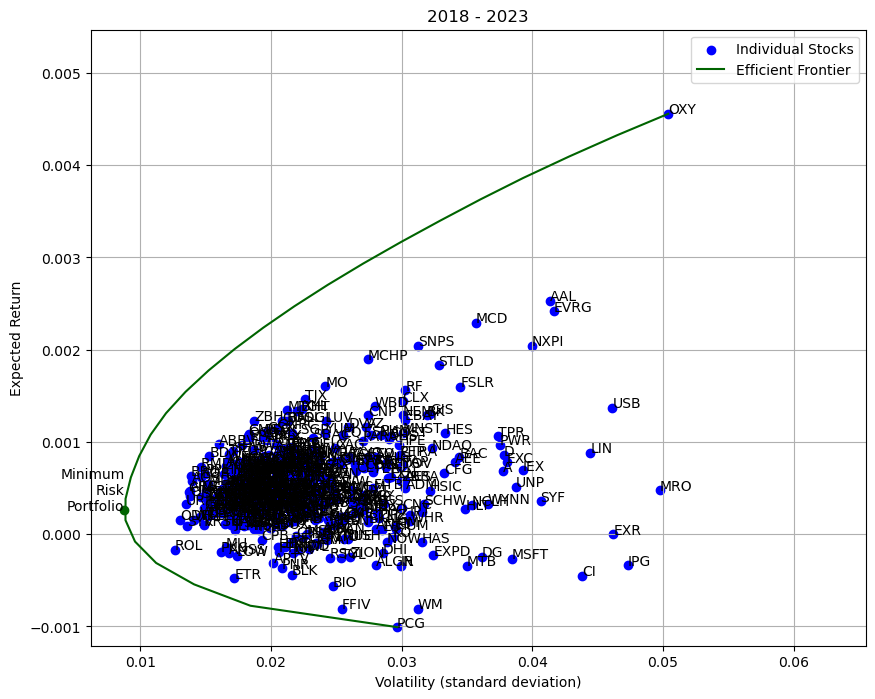

In [19]:
import matplotlib.pyplot as plt
#plt.figure(figsize=(10,10))

fig, ax = plt.subplots(figsize=(10,8))

# Plot volatility versus expected return for individual stocks
ax.scatter(x=std, y=delta,
           color='Blue', label='Individual Stocks')
for i, stock in enumerate(company_list):
    ax.annotate(stock, (std[i], delta[i]))

# Plot volatility versus expected return for minimum risk portfolio
ax.scatter(x=minrisk_volatility, y=minrisk_return, color='DarkGreen')
ax.annotate('Minimum\nRisk\nPortfolio', (minrisk_volatility, minrisk_return),
            horizontalalignment='right')

# Plot efficient frontier
ax.plot(frontier[0], frontier[1], label='Efficient Frontier', color='DarkGreen')

# Format and display the final plot
ax.axis([frontier[0].min()*0.7, frontier[0].max()*1.3, delta.min()*1.2, delta.max()*1.2])
ax.set_xlabel('Volatility (standard deviation)')
ax.set_ylabel('Expected Return')
ax.set_title('2018 - 2023')
ax.legend()
ax.grid()
plt.show()

# 2018

In [20]:
data2018 = yf.download(company_list, start="2018-01-01", end="2018-12-31", interval = "1d")

[*********************100%%**********************]  484 of 484 completed


In [21]:
import numpy as np

closes2018 = np.transpose(np.array(data2018.Close)) # matrix of daily closing prices
absdiff2018 = np.diff(closes2018)                   # change in closing price each day
reldiff2018 = np.divide(absdiff2018, closes2018[:,:-1]) # relative change in daily closing price
delta2018 = np.mean(reldiff2018, axis=1)            # mean price change
sigma2018 = np.cov(reldiff2018)                     # covariance (standard deviations)
std2018 = np.std(reldiff2018, axis=1)               # standard deviation

In [22]:
import gurobipy as gp
from gurobipy import GRB
from math import sqrt

# Create an empty model
m = gp.Model('portfolio')

# Add matrix variable for the stocks
x = m.addMVar(len(company_list))

# Objective is to minimize risk (squared).  This is modeled using the
# covariance matrix, which measures the historical correlation between stocks
portfolio_risk = x @ sigma2018 @ x
m.setObjective(portfolio_risk, GRB.MINIMIZE)

# Fix budget with a constraint
m.addConstr(x.sum() == 1, 'budget')

# Verify model formulation
m.write('portfolio_selection_optimization.lp')

# Optimize model to find the minimum risk portfolio
m.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1 rows, 484 columns and 484 nonzeros
Model fingerprint: 0x5bca9f3c
Model has 117370 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [3e-09, 6e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.12s
Presolved: 1 rows, 484 columns, 484 nonzeros
Presolved model has 117370 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 248
 AA' NZ     : 3.088e+04
 Factor NZ  : 3.112e+04 (roughly 1 MB of memory)
 Factor Ops : 5.177e+06 (less than 1 second per iteration)
 Threads    : 8

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   4.74553970e-10 -4.74553970e-10  4.84e+05 1.14e-05  1.

In [23]:
import pandas as pd
minrisk_volatility = sqrt(m.ObjVal)
minrisk_return = delta2018 @ x.X
pd.DataFrame(data=np.append(x.X, [minrisk_volatility, minrisk_return]),
             index=company_list + ['Volatility', 'Expected Return'],
             columns=['Minimum Risk Portfolio'])

,Minimum Risk Portfolio
AAPL,1.555883e-07
MSFT,2.039630e-07
AMZN,1.861493e-07
GOOGL,1.792996e-07
GOOG,1.574391e-07
...,...
DVA,8.677200e-08
DISH,5.725677e-07
NWS,1.505732e-07
Volatility,5.432576e-03


In [24]:
# Create an expression representing the expected return for the portfolio
portfolio_return = delta2018 @ x
target = m.addConstr(portfolio_return == minrisk_return, 'target')

# Solve for efficient frontier by varying target return
frontier = np.empty((2,0))
for r in np.linspace(delta2018.min(), delta2018.max(), 25):
    target.rhs = r
    m.optimize()
    frontier = np.append(frontier, [[sqrt(m.ObjVal)],[r]], axis=1)

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2 rows, 484 columns and 968 nonzeros
Model fingerprint: 0xdfa3c16d
Model has 117370 quadratic objective terms
Coefficient statistics:
  Matrix range     [2e-07, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [3e-09, 6e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-03, 1e+00]
Presolve time: 0.04s
Presolved: 2 rows, 484 columns, 968 nonzeros
Presolved model has 117370 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 248
 AA' NZ     : 3.112e+04
 Factor NZ  : 3.138e+04 (roughly 1 MB of memory)
 Factor Ops : 5.240e+06 (less than 1 second per iteration)
 Threads    : 8

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   8.36084019e-10 -8.36084019e-10  4.84e+05 1.16e-05  1.

  10   1.41228622e-04  3.44163423e-05  9.33e-15 8.67e-19  2.21e-07     1s
  11   1.16208920e-04  5.67752834e-05  1.69e-14 8.67e-19  1.23e-07     1s
  12   1.00159874e-04  8.44004681e-05  9.60e-15 4.34e-19  3.26e-08     1s
  13   9.08896023e-05  8.81671054e-05  1.47e-13 8.67e-19  5.62e-09     1s
  14   8.85598286e-05  8.84854288e-05  1.26e-13 8.67e-19  1.54e-10     1s
  15   8.84887427e-05  8.84885283e-05  1.31e-13 2.17e-19  4.43e-13     1s

Barrier solved model in 15 iterations and 1.39 seconds (0.07 work units)
Optimal objective 8.84887427e-05

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2 rows, 484 columns and 968 nonzeros
Model fingerprint: 0x136c0d81
Model has 117370 quadratic objective terms
Coefficient statistics:
  Matrix range     [2e-07, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [3e-09, 6e-03]
  Bounds range     [0e+00, 0e+

   2   1.11142191e-04 -9.92633331e+02  1.25e+00 2.96e-11  4.62e+00     0s
   3   1.11620283e-04 -4.65048157e+02  1.24e-01 2.95e-12  1.13e+00     0s
   4   1.09675900e-04 -1.65005891e+02  1.24e-07 2.93e-18  3.41e-01     1s
   5   1.09675830e-04 -1.65235388e-01  2.55e-13 1.07e-13  3.42e-04     1s
   6   1.09605840e-04 -3.93284977e-04  6.66e-16 3.22e-16  1.04e-06     1s
   7   9.07091045e-05 -4.64093606e-05  2.78e-17 4.02e-17  2.83e-07     1s
   8   6.16293598e-05 -2.08047375e-05  6.44e-15 1.08e-19  1.70e-07     1s
   9   4.88779464e-05  2.80061364e-05  7.11e-15 8.67e-19  4.31e-08     1s
  10   4.35514328e-05  3.20574884e-05  6.88e-15 4.34e-19  2.37e-08     1s
  11   3.94391359e-05  3.62808251e-05  2.22e-15 4.34e-19  6.53e-09     1s
  12   3.79433204e-05  3.70438623e-05  2.11e-15 4.34e-19  1.86e-09     1s
  13   3.73302130e-05  3.71754855e-05  4.55e-15 4.34e-19  3.20e-10     1s
  14   3.71949504e-05  3.71921306e-05  1.67e-15 2.17e-19  5.83e-12     1s

Barrier solved model in 14 iterations

 Threads    : 8

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   4.74932255e-10 -4.74932255e-10  4.84e+05 1.14e-05  1.00e+06     0s
   1   9.97931179e-05 -9.98985667e+02  4.84e+02 1.14e-08  1.00e+03     0s
   2   9.93197816e-05 -9.95288028e+02  1.13e-01 2.67e-12  2.29e+00     0s
   3   9.97634911e-05 -2.37136654e+01  1.22e-03 2.89e-14  4.91e-02     0s
   4   9.97746893e-05 -2.40052664e-02  2.17e-08 4.34e-19  4.98e-05     0s
   5   9.90071769e-05 -1.09308124e-04  1.32e-10 4.34e-19  4.30e-07     0s
   6   5.96080065e-05 -7.10495806e-05  6.66e-16 8.67e-19  2.70e-07     0s
   7   4.83764227e-05  1.41163563e-06  4.44e-16 8.67e-19  9.70e-08     1s
   8   3.85381507e-05  2.31268947e-05  1.67e-16 4.34e-19  3.18e-08     1s
   9   3.37985552e-05  2.80273478e-05  1.33e-15 4.34e-19  1.19e-08     1s
  10   3.13696452e-05  3.02169523e-05  6.22e-15 4.34e-19  2.38e-09     1s
  11   3.07165385e-05  3.03775153e-05  5.55

  RHS range        [1e-03, 1e+00]
Presolve time: 0.07s
Presolved: 2 rows, 484 columns, 968 nonzeros
Presolved model has 117370 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 248
 AA' NZ     : 3.112e+04
 Factor NZ  : 3.138e+04 (roughly 1 MB of memory)
 Factor Ops : 5.240e+06 (less than 1 second per iteration)
 Threads    : 8

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   4.71572412e-10 -4.71572412e-10  4.84e+05 1.14e-05  1.00e+06     0s
   1   1.10363408e-04 -9.98964156e+02  4.88e+02 1.15e-08  1.01e+03     0s
   2   1.18841180e-04 -9.84099238e+02  2.15e+00 5.06e-11  6.46e+00     0s
   3   1.73943969e-04 -5.47031423e+02  1.93e-01 4.55e-12  1.48e+00     0s
   4   1.99864034e-04 -8.28111085e+01  1.93e-07 4.50e-18  1.71e-01     0s
   5   1.99862521e-04 -8.40488188e-02  3.36e-12 5.02e-14  1.74e-04     0s
   6   1.98481931e-04 -1.17163838e-03  4.49e-14 7.32e-16  2.83e-06  

  Matrix range     [2e-07, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [3e-09, 6e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-03, 1e+00]
Presolve time: 0.08s
Presolved: 2 rows, 484 columns, 968 nonzeros
Presolved model has 117370 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 248
 AA' NZ     : 3.112e+04
 Factor NZ  : 3.138e+04 (roughly 1 MB of memory)
 Factor Ops : 5.240e+06 (less than 1 second per iteration)
 Threads    : 8

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   5.36462207e-10 -5.36462207e-10  4.84e+05 1.13e-05  1.00e+06     0s
   1   1.38115467e-04 -9.98925608e+02  4.92e+02 1.15e-08  1.02e+03     0s
   2   1.59894616e-04 -9.57782428e+02  4.30e+00 1.01e-10  1.08e+01     0s
   3   4.69687121e-04 -4.57733550e+02  3.09e-01 7.23e-12  1.71e+00     0s
   4   5.20379011e-04 -1.24418925e+02  9.20e-03 2.15e-13  2.64e-01     1s
   5  

Model fingerprint: 0xa00cef67
Model has 117370 quadratic objective terms
Coefficient statistics:
  Matrix range     [2e-07, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [3e-09, 6e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-03, 1e+00]
Presolve time: 0.05s
Presolved: 2 rows, 484 columns, 968 nonzeros
Presolved model has 117370 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 248
 AA' NZ     : 3.112e+04
 Factor NZ  : 3.138e+04 (roughly 1 MB of memory)
 Factor Ops : 5.240e+06 (less than 1 second per iteration)
 Threads    : 8

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   6.69601639e-10 -6.69601639e-10  4.84e+05 1.13e-05  1.00e+06     0s
   1   1.82974219e-04 -9.98870188e+02  4.96e+02 1.16e-08  1.03e+03     0s
   2   2.22473194e-04 -9.16659950e+02  6.37e+00 1.49e-10  1.50e+01     0s
   3   8.00089052e-04 -9.49362989e+01  9.91e-01 2.31e-11 

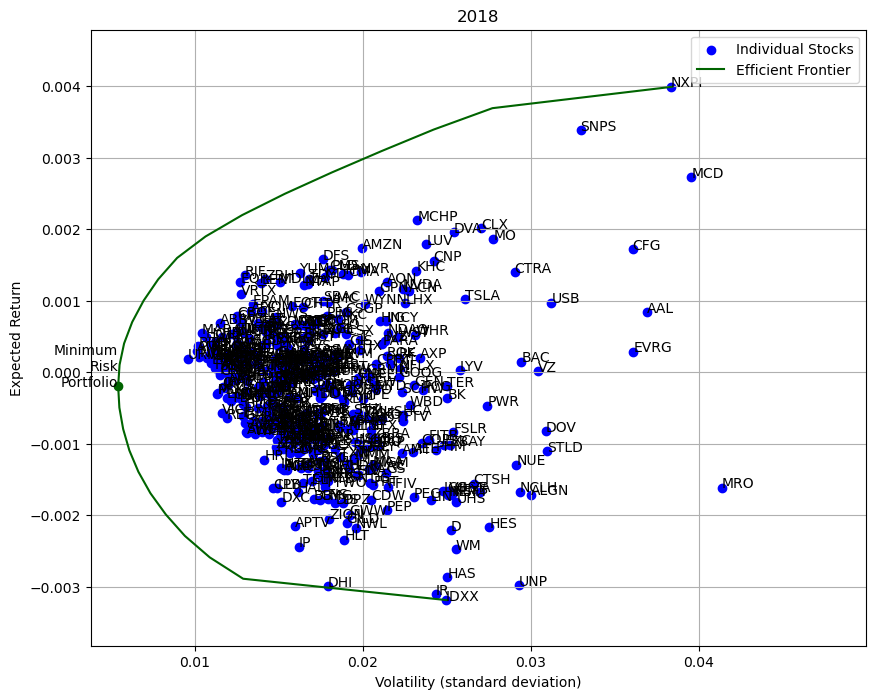

In [25]:
import matplotlib.pyplot as plt
#plt.figure(figsize=(10,10))

fig, ax = plt.subplots(figsize=(10,8))

# Plot volatility versus expected return for individual stocks
ax.scatter(x=std2018, y=delta2018,
           color='Blue', label='Individual Stocks')
for i, stock in enumerate(company_list):
    ax.annotate(stock, (std2018[i], delta2018[i]))

# Plot volatility versus expected return for minimum risk portfolio
ax.scatter(x=minrisk_volatility, y=minrisk_return, color='DarkGreen')
ax.annotate('Minimum\nRisk\nPortfolio', (minrisk_volatility, minrisk_return),
            horizontalalignment='right')

# Plot efficient frontier
ax.plot(frontier[0], frontier[1], label='Efficient Frontier', color='DarkGreen')

# Format and display the final plot
ax.axis([frontier[0].min()*0.7, frontier[0].max()*1.3, delta2018.min()*1.2, delta2018.max()*1.2])
ax.set_xlabel('Volatility (standard deviation)')
ax.set_ylabel('Expected Return')
ax.set_title('2018')
ax.legend()
ax.grid()
plt.show()

# 2022 - 2023

In [26]:
data2022 = yf.download(company_list, start="2022-01-01", end="2022-12-31", interval = "1d")

[*********************100%%**********************]  484 of 484 completed


In [27]:
import numpy as np

closes2022 = np.transpose(np.array(data2022.Close)) # matrix of daily closing prices
absdiff2022 = np.diff(closes2022)                   # change in closing price each day
reldiff2022 = np.divide(absdiff2022, closes2022[:,:-1]) # relative change in daily closing price
delta2022 = np.mean(reldiff2022, axis=1)            # mean price change
sigma2022 = np.cov(reldiff2022)                     # covariance (standard deviations)
std2022 = np.std(reldiff2022, axis=1)               # standard deviation

In [28]:
import gurobipy as gp
from gurobipy import GRB
from math import sqrt

# Create an empty model
m = gp.Model('portfolio')

# Add matrix variable for the stocks
x = m.addMVar(len(company_list))

# Objective is to minimize risk (squared).  This is modeled using the
# covariance matrix, which measures the historical correlation between stocks
portfolio_risk = x @ sigma2022 @ x
m.setObjective(portfolio_risk, GRB.MINIMIZE)

# Fix budget with a constraint
m.addConstr(x.sum() == 1, 'budget')

# Verify model formulation
m.write('portfolio_selection_optimization.lp')

# Optimize model to find the minimum risk portfolio
m.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1 rows, 484 columns and 484 nonzeros
Model fingerprint: 0x49f81913
Model has 117370 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [3e-08, 8e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.29s
Presolved: 1 rows, 484 columns, 484 nonzeros
Presolved model has 117370 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 249
 AA' NZ     : 3.112e+04
 Factor NZ  : 3.138e+04 (roughly 1 MB of memory)
 Factor Ops : 5.240e+06 (less than 1 second per iteration)
 Threads    : 8

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   9.71349281e-10 -9.71349281e-10  4.84e+05 1.31e-05  1.

In [29]:
import pandas as pd
minrisk_volatility = sqrt(m.ObjVal)
minrisk_return = delta2022 @ x.X
pd.DataFrame(data=np.append(x.X, [minrisk_volatility, minrisk_return]),
             index=company_list + ['Volatility', 'Expected Return'],
             columns=['Minimum Risk Portfolio'])

,Minimum Risk Portfolio
AAPL,2.313320e-07
MSFT,1.460239e-07
AMZN,3.353590e-07
GOOGL,1.677355e-07
GOOG,1.688581e-06
...,...
DVA,1.709985e-07
DISH,2.285991e-07
NWS,2.436053e-07
Volatility,7.721346e-03


In [30]:
# Create an expression representing the expected return for the portfolio
portfolio_return = delta2022 @ x
target = m.addConstr(portfolio_return == minrisk_return, 'target')

# Solve for efficient frontier by varying target return
frontier = np.empty((2,0))
for r in np.linspace(delta2022.min(), delta2022.max(), 25):
    target.rhs = r
    m.optimize()
    frontier = np.append(frontier, [[sqrt(m.ObjVal)],[r]], axis=1)

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2 rows, 484 columns and 968 nonzeros
Model fingerprint: 0xb4da48d9
Model has 117370 quadratic objective terms
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [3e-08, 8e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-03, 1e+00]
Presolve time: 0.08s
Presolved: 2 rows, 484 columns, 968 nonzeros
Presolved model has 117370 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 249
 AA' NZ     : 3.138e+04
 Factor NZ  : 3.163e+04 (roughly 1 MB of memory)
 Factor Ops : 5.303e+06 (less than 1 second per iteration)
 Threads    : 8

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.39425326e-09 -2.39425326e-09  4.84e+05 1.90e-05  1.

  12   4.15825313e-04  3.37311999e-04  9.38e-15 1.73e-18  1.62e-07     2s
  13   3.74031729e-04  3.34459525e-04  4.44e-16 8.67e-19  8.18e-08     2s
  14   3.62025295e-04  3.53277270e-04  2.88e-14 1.73e-18  1.81e-08     2s
  15   3.56632219e-04  3.56223169e-04  1.36e-13 1.73e-18  8.45e-10     2s
  16   3.56317715e-04  3.56317284e-04  5.16e-14 3.47e-18  8.90e-13     2s

Barrier solved model in 16 iterations and 1.83 seconds (0.07 work units)
Optimal objective 3.56317715e-04

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2 rows, 484 columns and 968 nonzeros
Model fingerprint: 0x4ba4f646
Model has 117370 quadratic objective terms
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [3e-08, 8e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-03, 1e+00]
Presolve time: 0.02s
Presolved: 2 ro

   3   3.71759719e-04 -4.63468089e+02  1.85e-01 5.73e-12  1.25e+00     0s
   4   4.57949720e-04 -2.28473816e+02  1.85e-07 6.94e-18  4.72e-01     0s
   5   4.57947945e-04 -2.31201237e-01  2.58e-12 2.51e-13  4.79e-04     0s
   6   4.56252189e-04 -2.63483859e-03  3.09e-14 2.96e-15  6.39e-06     1s
   7   3.60280212e-04 -1.15123967e-03  1.78e-15 3.47e-18  3.12e-06     1s
   8   2.90239883e-04  8.28748704e-06  6.38e-16 3.47e-18  5.83e-07     1s
   9   2.44424232e-04  8.27360862e-05  3.33e-15 1.73e-18  3.34e-07     1s
  10   1.90884145e-04  1.05230225e-04  8.88e-16 4.34e-19  1.77e-07     1s
  11   1.65306944e-04  1.40023815e-04  1.33e-15 1.73e-18  5.22e-08     1s
  12   1.51987130e-04  1.45958984e-04  2.96e-14 1.73e-18  1.25e-08     1s
  13   1.48016632e-04  1.46774415e-04  1.11e-15 8.67e-19  2.57e-09     1s
  14   1.46870334e-04  1.46849136e-04  5.80e-15 4.34e-19  4.38e-11     1s
  15   1.46850158e-04  1.46850136e-04  1.53e-14 2.17e-19  4.55e-14     1s

Barrier solved model in 15 iterations

 Threads    : 8

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.07198976e-09 -1.07198976e-09  4.84e+05 1.27e-05  1.00e+06     0s
   1   2.37127518e-04 -9.98984836e+02  4.83e+02 1.27e-08  1.00e+03     0s
   2   2.29882872e-04 -9.95761786e+02  4.83e-04 1.27e-14  2.06e+00     0s
   3   2.29883334e-04 -9.96045090e-01  4.83e-10 1.73e-18  2.06e-03     0s
   4   2.29819010e-04 -1.08719001e-03  1.56e-13 3.25e-18  2.72e-06     0s
   5   1.89435810e-04 -5.11131637e-05  1.95e-14 1.73e-18  4.97e-07     0s
   6   1.46697082e-04  7.77479246e-06  5.77e-15 4.34e-19  2.87e-07     0s
   7   1.06214138e-04  2.95487708e-05  9.99e-15 4.34e-19  1.58e-07     0s
   8   8.67182428e-05  6.29266100e-05  4.44e-16 1.73e-18  4.92e-08     0s
   9   7.57735689e-05  6.99041688e-05  8.22e-15 8.67e-19  1.21e-08     0s
  10   7.27785882e-05  7.09489666e-05  2.78e-15 8.67e-19  3.78e-09     1s
  11   7.13163736e-05  7.11464434e-05  2.22

 Factor Ops : 5.303e+06 (less than 1 second per iteration)
 Threads    : 8

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   9.68790098e-10 -9.68790098e-10  4.84e+05 1.32e-05  1.00e+06     0s
   1   1.66772811e-04 -9.98976043e+02  4.86e+02 1.33e-08  1.01e+03     0s
   2   1.68728143e-04 -9.92448656e+02  9.47e-01 2.59e-11  4.00e+00     0s
   3   1.85027918e-04 -4.12169808e+02  1.35e-01 3.70e-12  1.01e+00     0s
   4   2.06132148e-04 -1.25785291e+02  1.35e-07 3.69e-18  2.60e-01     1s
   5   2.06131586e-04 -1.26090063e-01  5.48e-13 7.56e-14  2.61e-04     1s
   6   2.05595157e-04 -4.25751926e-04  6.44e-15 3.40e-16  1.30e-06     1s
   7   1.37794490e-04 -1.44270577e-04  4.44e-16 1.73e-18  5.83e-07     1s
   8   1.02483131e-04 -2.02374304e-05  1.78e-15 1.73e-18  2.54e-07     1s
   9   8.75339570e-05  3.72192795e-05  1.60e-14 8.67e-19  1.04e-07     1s
  10   7.30026660e-05  5.72005343e-05  4.44e-16 4.34e-19  


Optimize a model with 2 rows, 484 columns and 968 nonzeros
Model fingerprint: 0x30e33c67
Model has 117370 quadratic objective terms
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [3e-08, 8e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-03, 1e+00]
Presolve time: 0.03s
Presolved: 2 rows, 484 columns, 968 nonzeros
Presolved model has 117370 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 249
 AA' NZ     : 3.138e+04
 Factor NZ  : 3.163e+04 (roughly 1 MB of memory)
 Factor Ops : 5.303e+06 (less than 1 second per iteration)
 Threads    : 8

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.06698960e-09 -1.06698960e-09  4.84e+05 1.43e-05  1.00e+06     0s
   1   1.50894281e-04 -9.98953137e+02  4.89e+02 1.45e-08  1.01e+03     0s
   2   1.68744685e-04 -9.78608648e+02  2.83e+00 8.39e-11  7.86e+00     

Optimal objective 4.37186864e-04

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2 rows, 484 columns and 968 nonzeros
Model fingerprint: 0x22bfa51d
Model has 117370 quadratic objective terms
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [3e-08, 8e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-03, 1e+00]
Presolve time: 0.05s
Presolved: 2 rows, 484 columns, 968 nonzeros
Presolved model has 117370 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 249
 AA' NZ     : 3.138e+04
 Factor NZ  : 3.163e+04 (roughly 1 MB of memory)
 Factor Ops : 5.303e+06 (less than 1 second per iteration)
 Threads    : 8

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.36658826e-09 -1.3

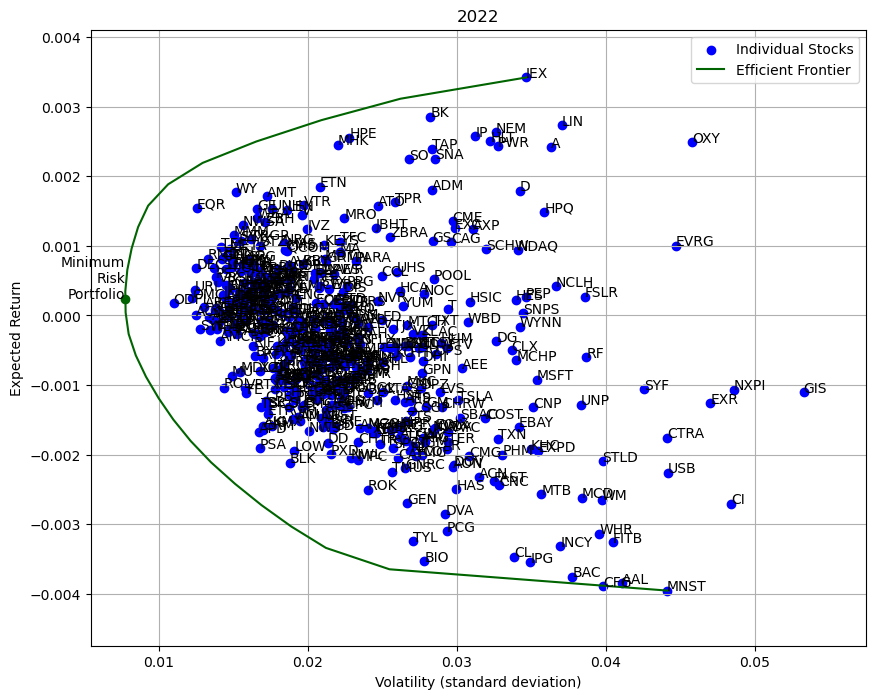

In [31]:
import matplotlib.pyplot as plt
#plt.figure(figsize=(10,10))

fig, ax = plt.subplots(figsize=(10,8))

# Plot volatility versus expected return for individual stocks
ax.scatter(x=std2022, y=delta2022,
           color='Blue', label='Individual Stocks')
for i, stock in enumerate(company_list):
    ax.annotate(stock, (std2022[i], delta2022[i]))

# Plot volatility versus expected return for minimum risk portfolio
ax.scatter(x=minrisk_volatility, y=minrisk_return, color='DarkGreen')
ax.annotate('Minimum\nRisk\nPortfolio', (minrisk_volatility, minrisk_return),
            horizontalalignment='right')

# Plot efficient frontier
ax.plot(frontier[0], frontier[1], label='Efficient Frontier', color='DarkGreen')

# Format and display the final plot
ax.axis([frontier[0].min()*0.7, frontier[0].max()*1.3, delta2022.min()*1.2, delta2022.max()*1.2])
ax.set_xlabel('Volatility (standard deviation)')
ax.set_ylabel('Expected Return')
ax.set_title('2022')
ax.legend()
ax.grid()
plt.show()

# More model
maximize return - variance

# 2018

In [32]:
import gurobipy as gp
from gurobipy import GRB
from math import sqrt

# Create an empty model
mod1 = gp.Model('portfolio_2')

# Add matrix variable for the stocks
x2 = mod1.addMVar(len(company_list), lb=0.0, ub = 0.2) # set upper bound to diversify portfolio
y2 = mod1.addVars(len(company_list), vtype=GRB.BINARY)

# Objective is to maximize return and minimize risk (squared)
portfolio_risk = x2 @ sigma2018 @ x2
portfolio_return = delta2018 @ x2

mod1.setObjective(portfolio_return - portfolio_risk, GRB.MAXIMIZE)

# Fix budget with a constraint
mod1.addConstr(x2.sum() == 1, 'budget')
    
# Add a constraint to ensure that if you buy stock i, you have to buy at least 2% of the portfolio
for i in range(len(company_list)):
    mod1.addConstr(x2[i] <= y2[i], f'buy_indicator_{i}')

for i in range(len(company_list)):
    mod1.addConstr(x2[i] >= 0.02 * y2[i], f'min_allocation_{i}')

# Verify model formulation
mod1.write('portfolio_selection_optimization_2.lp')

# Optimize model to find the minimum risk portfolio
mod1.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 969 rows, 968 columns and 2420 nonzeros
Model fingerprint: 0x119d125d
Model has 117370 quadratic objective terms
Variable types: 484 continuous, 484 integer (484 binary)
Coefficient statistics:
  Matrix range     [2e-02, 1e+00]
  Objective range  [2e-07, 4e-03]
  QObjective range [3e-09, 6e-03]
  Bounds range     [2e-01, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -0.0005856
Presolve time: 0.34s
Presolved: 969 rows, 968 columns, 2420 nonzeros
Presolved model has 117370 quadratic objective terms
Variable types: 484 continuous, 484 integer (484 binary)

Root relaxation: objective 2.625002e-03, 109 iterations, 0.02 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | I

In [33]:
import pandas as pd
minrisk_volatility = x2.X @ sigma2018 @ x2.X
minrisk_return = delta2018 @ x2.X
Result = pd.DataFrame(data=np.append(x2.X, [minrisk_volatility, minrisk_return]),
             index=company_list + ['Volatility', 'Expected Return'],
             columns=['Minimum Risk Portfolio'])

In [34]:
Result[Result['Minimum Risk Portfolio'] > 0]

,Minimum Risk Portfolio
MCD,0.200000
MO,0.107406
SNPS,0.200000
OXY,0.200000
NXPI,0.200000
MCHP,0.070801
DVA,0.021793
Volatility,0.000548
Expected Return,0.003173


# At least 10 different stocks

In [35]:
import gurobipy as gp
from gurobipy import GRB
from math import sqrt

# Create an empty model
mod2 = gp.Model('portfolio_diversification')

# Add matrix variable for the stocks
x2 = mod2.addMVar(len(company_list), lb=0.0, ub = 0.2) # set upper bound to diversify portfolio
y2 = mod2.addVars(len(company_list), vtype=GRB.BINARY)

# Objective is to maximize return and minimize risk (squared)
portfolio_risk = x2 @ sigma2018 @ x2
portfolio_return = delta2018 @ x2

mod2.setObjective(portfolio_return - portfolio_risk, GRB.MAXIMIZE)

# Fix budget with a constraint
mod2.addConstr(x2.sum() == 1, 'budget')
mod2.addConstr(y2.sum() >= 10, 'diversification')

    
# Add a constraint to ensure that if you buy stock i, you have to buy at least 2% of the portfolio
for i in range(len(company_list)):
    mod2.addConstr(x2[i] <= y2[i], f'buy_indicator_{i}')

for i in range(len(company_list)):
    mod2.addConstr(x2[i] >= 0.02 * y2[i], f'min_allocation_{i}')

# Verify model formulation
mod2.write('portfolio_selection_optimization_2.lp')

# Optimize model to find the minimum risk portfolio
mod2.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 970 rows, 968 columns and 2904 nonzeros
Model fingerprint: 0xcead449d
Model has 117370 quadratic objective terms
Variable types: 484 continuous, 484 integer (484 binary)
Coefficient statistics:
  Matrix range     [2e-02, 1e+00]
  Objective range  [2e-07, 4e-03]
  QObjective range [3e-09, 6e-03]
  Bounds range     [2e-01, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective -0.0002791
Presolve time: 0.12s
Presolved: 970 rows, 968 columns, 2904 nonzeros
Presolved model has 117370 quadratic objective terms
Variable types: 484 continuous, 484 integer (484 binary)

Root relaxation: objective 2.621169e-03, 1776 iterations, 0.08 seconds (0.08 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | 

In [36]:
minrisk_volatility = x2.X @ sigma2018 @ x2.X
minrisk_return = delta2018 @ x2.X
Result = pd.DataFrame(data=np.append(x2.X, [minrisk_volatility, minrisk_return]),
             index=company_list + ['Volatility', 'Expected Return'],
             columns=['Minimum Risk Portfolio'])

In [37]:
Result[Result['Minimum Risk Portfolio'] > 0]

,Minimum Risk Portfolio
AMZN,0.020000
MCD,0.200000
MO,0.088893
SNPS,0.200000
OXY,0.200000
NXPI,0.200000
MCHP,0.031107
LUV,0.020000
CLX,0.020000
DVA,0.020000


# Different industries 2018

In [38]:
df = pd.read_csv("SP 500 ESG Risk Ratings.csv")

In [39]:
companies = df.Symbol.tolist()
industry = df.Sector.tolist()

In [40]:
company_industry_dict = dict(zip(companies, industry))

In [41]:
company_industry_dict['AAPL']

'Technology'

In [42]:
company_industry = []
for val in company_list:
    if val in company_industry_dict:
        if not company_industry_dict[val] == "":
            company_industry.append(company_industry_dict[val])
    else:
        print(val)

XOM
SBNY
LUMN
DISH


In [43]:
company_industry_dict["XOM"] = 'Energy'
company_industry_dict["LUMN"] = 'Communication Services'
company_industry_dict['DISH'] = 'Communication Services'
company_industry_dict['SBNY'] = 'Financial Services'
company_industry_dict['CAT']='Industrials'

In [44]:
total = 0
company_list = sorted(company_list)
company_sector = []
for val in company_list:
    company_sector.append(company_industry_dict[val])

In [45]:
company_industry_dict_2018 = dict(zip(company_list, company_sector))

In [46]:
unique_values = set(company_industry_dict_2018.values())

In [47]:
company_industry_dict = dict(sorted(company_industry_dict.items()))

In [48]:
company_industry_dict_2018 = dict(sorted(company_industry_dict_2018.items()))

In [49]:
import gurobipy as gp
from gurobipy import GRB
from math import sqrt

# Create an empty model
mod3 = gp.Model('portfolio_diversification')

# Add matrix variable for the stocks
x2 = mod3.addMVar(len(company_list), lb=0.0, ub = 0.2) # set upper bound to diversify portfolio
y2 = mod3.addVars(len(company_list), vtype=GRB.BINARY)

# Objective is to maximize return and minimize risk (squared)
portfolio_risk = x2 @ sigma2018 @ x2
portfolio_return = delta2018 @ x2

mod3.setObjective(portfolio_return - portfolio_risk, GRB.MAXIMIZE)

# Fix budget with a constraint
mod3.addConstr(x2.sum() == 1, 'budget')
#mod3.addConstr(y2.sum() >= 10, 'diversification')

    
# Add a constraint to ensure that if you buy stock i, you have to buy at least 2% of the portfolio
for i in range(len(company_list)):
    mod3.addConstr(x2[i] <= y2[i], f'buy_indicator_{i}')

for i in range(len(company_list)):
    mod3.addConstr(x2[i] >= 0.02 * y2[i], f'min_allocation_{i}')

sectors = set(company_industry_dict_2018.values())
for sector in sectors:
    sector_indices = []
    for i in range(len(company_industry_dict_2018)):
        if company_industry_dict_2018[company_list[i]] == sector:
            sector_indices.append(i)
    mod3.addConstr(gp.quicksum(x2[i] for i in sector_indices) <= 0.25, f'sector_limit_{sector}') #can't have more than 20% in any sector

# Verify model formulation
mod3.write('portfolio_selection_optimization_2.lp')

# Optimize model to find the minimum risk portfolio
mod3.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 980 rows, 968 columns and 2904 nonzeros
Model fingerprint: 0xde8b1ebc
Model has 117370 quadratic objective terms
Variable types: 484 continuous, 484 integer (484 binary)
Coefficient statistics:
  Matrix range     [2e-02, 1e+00]
  Objective range  [2e-07, 4e-03]
  QObjective range [3e-09, 6e-03]
  Bounds range     [2e-01, 1e+00]
  RHS range        [2e-01, 1e+00]
Found heuristic solution: objective -0.0004865
Presolve time: 0.15s
Presolved: 980 rows, 968 columns, 2904 nonzeros
Presolved model has 117370 quadratic objective terms
Variable types: 484 continuous, 484 integer (484 binary)

Root relaxation: objective 2.494410e-03, 107 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | I

In [50]:
minrisk_volatility = x2.X @ sigma2018 @ x2.X
minrisk_return = delta2018 @ x2.X
Result = pd.DataFrame(data=np.append(x2.X, [minrisk_volatility, minrisk_return]),
             index=company_list + ['Volatility', 'Expected Return'],
             columns=['Minimum Risk Portfolio'])

In [51]:
Result[Result['Minimum Risk Portfolio'] > 0]

,Minimum Risk Portfolio
AMD,0.050000
CHD,0.020000
CMG,0.050000
DXCM,0.200000
ENPH,0.200000
ETSY,0.200000
MKC,0.200000
MOH,0.050000
MTCH,0.030000
Volatility,0.000407


In [52]:
def get_industry_2018(ticker):
    return company_industry_dict_2018[ticker]

In [53]:
portfolio_with_industry = Result
portfolio_with_industry = portfolio_with_industry.reset_index()
portfolio_with_industry = portfolio_with_industry.iloc[:-2]
portfolio_with_industry.rename(columns={'index': 'Ticker'}, inplace=True)
portfolio_with_industry['Industry'] = portfolio_with_industry['Ticker'].apply(get_industry_2018)
portfolio_with_industry[portfolio_with_industry['Minimum Risk Portfolio'] > 0]

,Ticker,Minimum Risk Portfolio,Industry
28,AMD,0.05,Technology
85,CHD,0.02,Consumer Defensive
95,CMG,0.05,Consumer Cyclical
140,DXCM,0.20,Healthcare
151,ENPH,0.20,Technology
161,ETSY,0.20,Consumer Cyclical
290,MKC,0.20,Consumer Defensive
297,MOH,0.05,Healthcare
308,MTCH,0.03,Communication Services


In [54]:
portfolio_grouped_by_industry_2018 = portfolio_with_industry.groupby('Industry')['Minimum Risk Portfolio'].sum().reset_index()

In [55]:
portfolio_grouped_by_industry_2018[portfolio_grouped_by_industry_2018['Minimum Risk Portfolio'] > 0].sort_values(by='Minimum Risk Portfolio', ascending=False)

,Industry,Minimum Risk Portfolio
2,Consumer Cyclical,0.25
6,Healthcare,0.25
9,Technology,0.25
3,Consumer Defensive,0.22
1,Communication Services,0.03


# Different industries 2022

In [56]:
company_list_2022 = sorted(list(data2022.columns.get_level_values(1).unique()))

In [57]:
len(company_list_2022)

484

In [58]:
company_industry_2022 = []
for val in company_list_2022:
    if val in company_industry_dict:
        if not company_industry_dict[val] == "":
            company_industry_2022.append(company_industry_dict[val])
    else:
        print(val)

In [59]:
len(company_industry_2022)

484

In [60]:
company_industry_dict_2022 = dict(zip(company_list_2022, company_industry_2022))

In [61]:
len(company_industry_dict_2022)

484

In [62]:
company_industry_dict_2022 = dict(sorted(company_industry_dict_2022.items()))

In [63]:
len(company_industry_dict_2022)

484

In [70]:
import gurobipy as gp
from gurobipy import GRB
from math import sqrt

# Create an empty model
mod4 = gp.Model('portfolio_diversification')

# Add matrix variable for the stocks
x2 = mod4.addMVar(len(company_list_2022), lb=0.0, ub = 0.2) # set upper bound to diversify portfolio
y2 = mod4.addVars(len(company_list_2022), vtype=GRB.BINARY)

# Objective is to maximize return and minimize risk (squared)
portfolio_risk = x2 @ sigma2022 @ x2
portfolio_return = delta2022 @ x2

mod4.setObjective(portfolio_return - portfolio_risk, GRB.MAXIMIZE)

# Fix budget with a constraint
mod4.addConstr(x2.sum() == 1, 'budget')

    
# Add a constraint to ensure that if you buy stock i, you have to buy at least 2% of the portfolio
for i in range(len(company_list_2022)):
    mod4.addConstr(x2[i] <= y2[i], f'buy_indicator_{i}')

for i in range(len(company_list_2022)):
    mod4.addConstr(x2[i] >= 0.02 * y2[i], f'min_allocation_{i}')

sectors = set(company_industry_dict_2022.values())
for sector in sectors:
    sector_indices = []
    for i in range(len(company_industry_dict_2022)):
        if company_industry_dict_2022[company_list_2022[i]] == sector:
            sector_indices.append(i)
    mod4.addConstr(gp.quicksum(x2[i] for i in sector_indices) <= 0.25, f'sector_limit_{sector}') #can't have more than 20% in any sector

# Verify model formulation
mod4.write('portfolio_selection_optimization_2.lp')

# Optimize model to find the minimum risk portfolio
mod4.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 980 rows, 968 columns and 2904 nonzeros
Model fingerprint: 0x0307742e
Model has 117370 quadratic objective terms
Variable types: 484 continuous, 484 integer (484 binary)
Coefficient statistics:
  Matrix range     [2e-02, 1e+00]
  Objective range  [2e-06, 4e-03]
  QObjective range [3e-08, 8e-03]
  Bounds range     [2e-01, 1e+00]
  RHS range        [2e-01, 1e+00]
Found heuristic solution: objective -0.0002178
Presolve time: 0.12s
Presolved: 980 rows, 968 columns, 2904 nonzeros
Presolved model has 117370 quadratic objective terms
Variable types: 484 continuous, 484 integer (484 binary)

Root relaxation: objective 2.126362e-03, 81 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It

In [71]:
minrisk_volatility = x2.X @ sigma2022 @ x2.X
minrisk_return = delta2022 @ x2.X
Result = pd.DataFrame(data=np.append(x2.X, [minrisk_volatility, minrisk_return]),
             index=company_list_2022 + ['Volatility', 'Expected Return'],
             columns=['Minimum Risk Portfolio'])
Result[Result['Minimum Risk Portfolio'] > 0].sort_values(by='Minimum Risk Portfolio', ascending=False)

,Minimum Risk Portfolio
FSLR,0.200000
MCK,0.200000
OXY,0.200000
STLD,0.200000
ENPH,0.050000
HES,0.050000
MRK,0.050000
LW,0.030000
NOC,0.020000
Expected Return,0.002436


In [72]:
def get_industry_2022(ticker):
    return company_industry_dict_2022[ticker]

In [73]:
portfolio_with_industry = Result
portfolio_with_industry = portfolio_with_industry.reset_index()
portfolio_with_industry = portfolio_with_industry.iloc[:-2]
portfolio_with_industry.rename(columns={'index': 'Ticker'}, inplace=True)
portfolio_with_industry['Industry'] = portfolio_with_industry['Ticker'].apply(get_industry_2022)
portfolio_with_industry[portfolio_with_industry['Minimum Risk Portfolio'] > 0]

,Ticker,Minimum Risk Portfolio,Industry
151,ENPH,0.05,Technology
181,FSLR,0.20,Technology
205,HES,0.05,Energy
273,LW,0.03,Consumer Defensive
282,MCK,0.20,Healthcare
301,MRK,0.05,Healthcare
319,NOC,0.02,Industrials
339,OXY,0.20,Energy
402,STLD,0.20,Basic Materials


In [74]:
portfolio_grouped_by_industry_2022 = portfolio_with_industry.groupby('Industry')['Minimum Risk Portfolio'].sum().reset_index()
portfolio_grouped_by_industry_2022[portfolio_grouped_by_industry_2018['Minimum Risk Portfolio'] > 0].sort_values(by='Minimum Risk Portfolio', ascending=False)

,Industry,Minimum Risk Portfolio
6,Healthcare,0.25
9,Technology,0.25
3,Consumer Defensive,0.03
1,Communication Services,0.00
2,Consumer Cyclical,0.00


# Jan 2018 to Dec 2019

In [75]:
data2018_2019 = yf.download(company_list, start="2018-01-01", end="2019-12-31", interval = "1d")

[*********************100%%**********************]  484 of 484 completed


In [76]:
company_list_2018_2019 = sorted(list(data2018_2019.columns.get_level_values(1).unique()))
len(company_list_2018_2019)

484

In [77]:
closes2018_2019 = np.transpose(np.array(data2018_2019.Close)) # matrix of daily closing prices
absdiff2018_2019 = np.diff(closes2018_2019)                   # change in closing price each day
reldiff2018_2019 = np.divide(absdiff2018_2019, closes2018_2019[:,:-1]) # relative change in daily closing price
delta2018_2019 = np.mean(reldiff2018_2019, axis=1)            # mean price change
sigma2018_2019 = np.cov(reldiff2018_2019)                     # covariance (standard deviations) between 2 stocks
std2018_2019 = np.std(reldiff2018_2019, axis=1)               # standard deviation

In [78]:
import gurobipy as gp
from gurobipy import GRB
from math import sqrt

# Create an empty model
mod5 = gp.Model('portfolio_diversification')

# Add matrix variable for the stocks
x2 = mod5.addMVar(len(company_list_2018_2019), lb=0.0, ub = 0.2) # set upper bound to diversify portfolio
y2 = mod5.addVars(len(company_list_2018_2019), vtype=GRB.BINARY)

# Objective is to maximize return and minimize risk (squared)
portfolio_risk = x2 @ sigma2018_2019 @ x2
portfolio_return = delta2018_2019 @ x2

mod5.setObjective(portfolio_return - portfolio_risk, GRB.MAXIMIZE)

# Fix budget with a constraint
mod5.addConstr(x2.sum() == 1, 'budget')

# Add a constraint to ensure that if you buy stock i, you have to buy at least 2% of the portfolio
for i in range(len(company_list_2018_2019)):
    mod5.addConstr(x2[i] <= y2[i], f'buy_indicator_{i}')

for i in range(len(company_list_2018_2019)):
    mod5.addConstr(x2[i] >= 0.02 * y2[i], f'min_allocation_{i}')

# Verify model formulation
mod5.write('portfolio_selection_optimization_2.lp')

# Optimize model to find the minimum risk portfolio
mod5.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 969 rows, 968 columns and 2420 nonzeros
Model fingerprint: 0x4784519a
Model has 117370 quadratic objective terms
Variable types: 484 continuous, 484 integer (484 binary)
Coefficient statistics:
  Matrix range     [2e-02, 1e+00]
  Objective range  [2e-07, 6e-03]
  QObjective range [5e-09, 1e-02]
  Bounds range     [2e-01, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -0.0000099
Presolve time: 0.36s
Presolved: 969 rows, 968 columns, 2420 nonzeros
Presolved model has 117370 quadratic objective terms
Variable types: 484 continuous, 484 integer (484 binary)

Root relaxation: objective 3.077289e-03, 110 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | I

In [79]:
minrisk_volatility = x2.X @ sigma2018_2019 @ x2.X
minrisk_return = delta2018_2019 @ x2.X
Result = pd.DataFrame(data=np.append(x2.X, [minrisk_volatility, minrisk_return]),
             index=company_list_2018_2019 + ['Volatility', 'Expected Return'],
             columns=['Minimum Risk Portfolio'])
Result[Result['Minimum Risk Portfolio'] > 0]

,Minimum Risk Portfolio
AMD,0.200000
CMG,0.200000
DXCM,0.200000
ENPH,0.200000
PAYC,0.200000
Volatility,0.000399
Expected Return,0.003476


# Jan 2020 to Dec 2021

In [80]:
data2020_2021 = yf.download(company_list, start="2020-01-01", end="2021-12-31", interval = "1d")

[*********************100%%**********************]  484 of 484 completed


In [81]:
company_list_2020_2021 = sorted(list(data2020_2021.columns.get_level_values(1).unique()))
len(company_list_2020_2021)

484

In [82]:
closes2020_2021 = np.transpose(np.array(data2020_2021.Close)) # matrix of daily closing prices
absdiff2020_2021 = np.diff(closes2020_2021)                   # change in closing price each day
reldiff2020_2021 = np.divide(absdiff2020_2021, closes2020_2021[:,:-1]) # relative change in daily closing price
delta2020_2021 = np.mean(reldiff2020_2021, axis=1)            # mean price change
sigma2020_2021 = np.cov(reldiff2020_2021)                     # covariance (standard deviations) between 2 stocks
std2020_2021 = np.std(reldiff2020_2021, axis=1)               # standard deviation

In [83]:
import gurobipy as gp
from gurobipy import GRB
from math import sqrt

# Create an empty model
mod6 = gp.Model('portfolio_diversification')

# Add matrix variable for the stocks
x2 = mod6.addMVar(len(company_list_2020_2021), lb=0.0, ub = 0.2) # set upper bound to diversify portfolio
y2 = mod6.addVars(len(company_list_2020_2021), vtype=GRB.BINARY)

# Objective is to maximize return and minimize risk (squared)
portfolio_risk = x2 @ sigma2020_2021 @ x2
portfolio_return = delta2020_2021 @ x2

mod6.setObjective(portfolio_return - portfolio_risk, GRB.MAXIMIZE)

# Fix budget with a constraint
mod6.addConstr(x2.sum() == 1, 'budget')

# Add a constraint to ensure that if you buy stock i, you have to buy at least 2% of the portfolio
for i in range(len(company_list_2020_2021)):
    mod6.addConstr(x2[i] <= y2[i], f'buy_indicator_{i}')

for i in range(len(company_list_2020_2021)):
    mod6.addConstr(x2[i] >= 0.02 * y2[i], f'min_allocation_{i}')

# Verify model formulation
mod6.write('portfolio_selection_optimization_2.lp')

# Optimize model to find the minimum risk portfolio
mod6.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 969 rows, 968 columns and 2420 nonzeros
Model fingerprint: 0xcaea7cfd
Model has 117370 quadratic objective terms
Variable types: 484 continuous, 484 integer (484 binary)
Coefficient statistics:
  Matrix range     [2e-02, 1e+00]
  Objective range  [1e-06, 6e-03]
  QObjective range [3e-08, 1e-02]
  Bounds range     [2e-01, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 0.0001818
Presolve time: 0.68s
Presolved: 969 rows, 968 columns, 2420 nonzeros
Presolved model has 117370 quadratic objective terms
Variable types: 484 continuous, 484 integer (484 binary)

Root relaxation: objective 3.634445e-03, 82 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/

In [84]:
minrisk_volatility = x2.X @ sigma2020_2021 @ x2.X
minrisk_return = delta2020_2021 @ x2.X
Result = pd.DataFrame(data=np.append(x2.X, [minrisk_volatility, minrisk_return]),
             index=company_list_2020_2021 + ['Volatility', 'Expected Return'],
             columns=['Minimum Risk Portfolio'])
Result[Result['Minimum Risk Portfolio'] > 0]

,Minimum Risk Portfolio
BBWI,0.200000
ENPH,0.200000
ETSY,0.200000
NVDA,0.200000
TSLA,0.200000
Volatility,0.001015
Expected Return,0.004649


# Jan 2022 to Mar 2023

In [85]:
data2022_2023 = yf.download(company_list, start="2022-01-01", end="2023-03-31", interval = "1d")

[*********************100%%**********************]  484 of 484 completed


In [86]:
company_list_2022_2023 = sorted(list(data2022_2023.columns.get_level_values(1).unique()))
len(company_list_2022_2023)

484

In [87]:
closes2022_2023 = np.transpose(np.array(data2022_2023.Close)) # matrix of daily closing prices
absdiff2022_2023 = np.diff(closes2022_2023)                   # change in closing price each day
reldiff2022_2023 = np.divide(absdiff2022_2023, closes2022_2023[:,:-1]) # relative change in daily closing price
delta2022_2023 = np.mean(reldiff2022_2023, axis=1)            # mean price change
sigma2022_2023 = np.cov(reldiff2022_2023)                     # covariance (standard deviations) between 2 stocks
std2022_2023 = np.std(reldiff2022_2023, axis=1)               # standard deviation

In [88]:
import gurobipy as gp
from gurobipy import GRB
from math import sqrt

# Create an empty model
mod7 = gp.Model('portfolio_diversification')

# Add matrix variable for the stocks
x2 = mod7.addMVar(len(company_list_2022_2023), lb=0.0, ub = 0.2) # set upper bound to diversify portfolio
y2 = mod7.addVars(len(company_list_2022_2023), vtype=GRB.BINARY)

# Objective is to maximize return and minimize risk (squared)
portfolio_risk = x2 @ sigma2022_2023 @ x2
portfolio_return = delta2022_2023 @ x2

mod7.setObjective(portfolio_return - portfolio_risk, GRB.MAXIMIZE)

# Fix budget with a constraint
mod7.addConstr(x2.sum() == 1, 'budget')

# Add a constraint to ensure that if you buy stock i, you have to buy at least 2% of the portfolio
for i in range(len(company_list_2022_2023)):
    mod7.addConstr(x2[i] <= y2[i], f'buy_indicator_{i}')

for i in range(len(company_list_2022_2023)):
    mod7.addConstr(x2[i] >= 0.02 * y2[i], f'min_allocation_{i}')

# Verify model formulation
mod7.write('portfolio_selection_optimization_2.lp')

# Optimize model to find the minimum risk portfolio
mod7.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 969 rows, 968 columns and 2420 nonzeros
Model fingerprint: 0x3bc4e2e4
Model has 117370 quadratic objective terms
Variable types: 484 continuous, 484 integer (484 binary)
Coefficient statistics:
  Matrix range     [2e-02, 1e+00]
  Objective range  [1e-07, 5e-03]
  QObjective range [2e-08, 1e-02]
  Bounds range     [2e-01, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 0.0003410
Presolve time: 0.16s
Presolved: 969 rows, 968 columns, 2420 nonzeros
Presolved model has 117370 quadratic objective terms
Variable types: 484 continuous, 484 integer (484 binary)

Root relaxation: objective 2.230914e-03, 57 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/

In [89]:
minrisk_volatility = x2.X @ sigma2022_2023 @ x2.X
minrisk_return = delta2022_2023 @ x2.X
Result = pd.DataFrame(data=np.append(x2.X, [minrisk_volatility, minrisk_return]),
             index=company_list_2022_2023 + ['Volatility', 'Expected Return'],
             columns=['Minimum Risk Portfolio'])
Result[Result['Minimum Risk Portfolio'] > 0]

,Minimum Risk Portfolio
FSLR,0.200000
LW,0.090391
MPC,0.200000
OXY,0.200000
STLD,0.200000
VLO,0.109609
Volatility,0.000369
Expected Return,0.002600
